In [1]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc

from pathlib import Path
import random
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

torch.cuda.is_available()

True

In [2]:
!ls part1

100_1_0_20170110183726390.jpg  35_0_0_20170104201742041.jpg
100_1_2_20170105174847679.jpg  35_0_0_20170104202556995.jpg
100_1_2_20170110182836729.jpg  35_0_0_20170104203145138.jpg
101_1_2_20170105174739309.jpg  35_0_0_20170104204813467.jpg
10_0_0_20161220222308131.jpg   35_0_0_20170104210200460.jpg
10_0_0_20170103200329407.jpg   35_0_0_20170105161456219.jpg
10_0_0_20170103200522151.jpg   35_0_0_20170105163316787.jpg
10_0_0_20170103233459275.jpg   35_0_0_20170105163921171.jpg
10_0_0_20170104013211746.jpg   35_0_0_20170105163947659.jpg
10_0_0_20170110215927291.jpg   35_0_0_20170105164841588.jpg
10_0_0_20170110220033115.jpg   35_0_0_20170105165146660.jpg
10_0_0_20170110220111082.jpg   35_0_0_20170105172434989.jpg
10_0_0_20170110220235233.jpg   35_0_0_20170105172445389.jpg
10_0_0_20170110220251986.jpg   35_0_0_20170105172518557.jpg
10_0_0_20170110220255346.jpg   35_0_0_20170105172523741.jpg
10_0_0_20170110220316298.jpg   35_0_0_20170108224654643.jpg
10_0_0_20170110220403810.jpg   35_0_0_20

In [3]:
path = Path("part1")

In [4]:
files = path.ls(); files #el primer numerito es la edad

(#9375) [Path('part1/48_0_1_20170111203549741.jpg'),Path('part1/26_0_0_20170104230421569.jpg'),Path('part1/1_0_0_20170109193820009.jpg'),Path('part1/52_0_0_20170104212243804.jpg'),Path('part1/30_1_2_20170104164904841.jpg'),Path('part1/13_1_0_20170104005742384.jpg'),Path('part1/62_0_0_20170111222711250.jpg'),Path('part1/28_1_2_20170104021739676.jpg'),Path('part1/10_0_3_20161220215952636.jpg'),Path('part1/1_1_0_20170109190936410.jpg')...]

In [5]:
def obtener_edad(archivo):
    return float(archivo.name.split("_")[0])

1_1_4_20161221201723169.jpg-->1.0


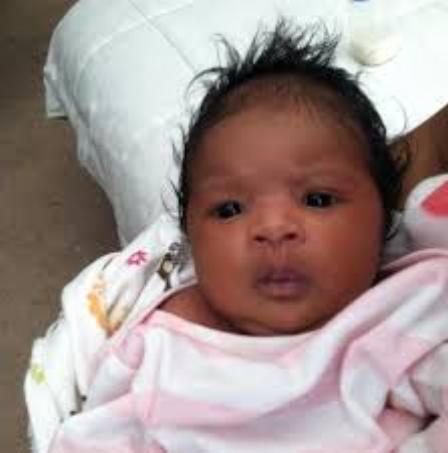

In [6]:
f = random.choice(files)
print(f"{f.name}-->{obtener_edad(f)}")
fv.PILImage.create(f) #Agarre a alguien al azar.

In [7]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size,
                             flip_vert = False, #una persona al revés no se ve tan bien
                             max_rotate = 10,
                             max_lighting = 0.25,
                             max_zoom = 1.1,
                             max_warp = 0.1 #no quiero que se vean tan distorcionadas las caras 
                            )
    
    data = fv.DataBlock(blocks     = (fv.ImageBlock, fv.RegressionBlock), #ojo con el segundo parámetro
                        get_items = fv.get_image_files,
                        get_y = obtener_edad,
                        splitter = fv.RandomSplitter(1/20), 
                        item_tfms = fv.Resize(int(1.5*img_size)),
                        batch_tfms = tfms,
    )
    return data.dataloaders(folder, bs=batch_size)
                             

In [8]:
data = load_data(path, img_size=192, batch_size=128)

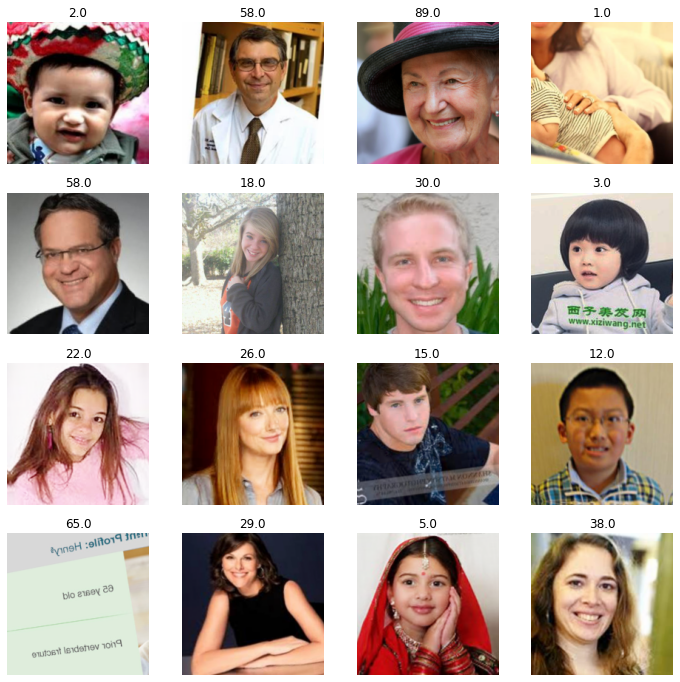

In [9]:
data.show_batch(max_n=16)

In [10]:
learn = fv.cnn_learner(data,fv.resnet18,normalize=False)

RuntimeError: number of dims don't match in permute

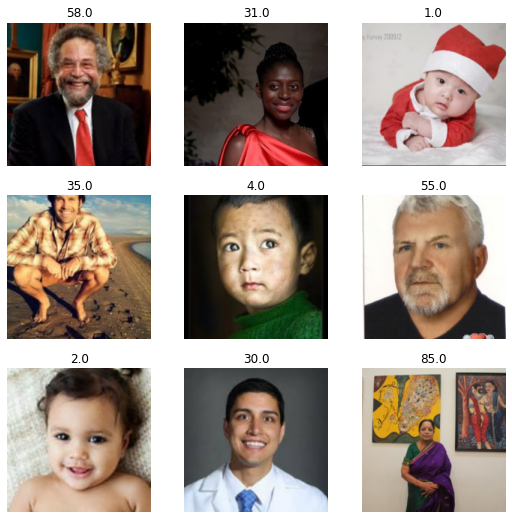

In [11]:
learn.show_results()

Lo anterior me da error:

In [12]:
def show_results(self, max_n=16):
    dl = self.dls.valid.new(shuffle=True) #preferimos ver los resultados en el set de validación
    x,y = dl.one_batch()
    yp = self.model(x).view(-1) #pasa el modelo por la batch, le quita la dimensión de 1
    ctx = fv.get_grid(max_n) #es lo que dibuja, como una imagen de matplotlib, te regresa un contexto para ir dibujando
    for i in range(max_n):
        fv.show_image(x[i], ctx=ctx[i], title=f"{yp[i]:.1f} | {int(y[i])} (delta = {y[i]- yp[i]:.1f})") #solmamente imprime un decima
        #la imagen i dibújala en el contexto i, ponle su edad y la diferencia entre edad real y edad predicha

In [13]:
fv.Learner.show_results = show_results

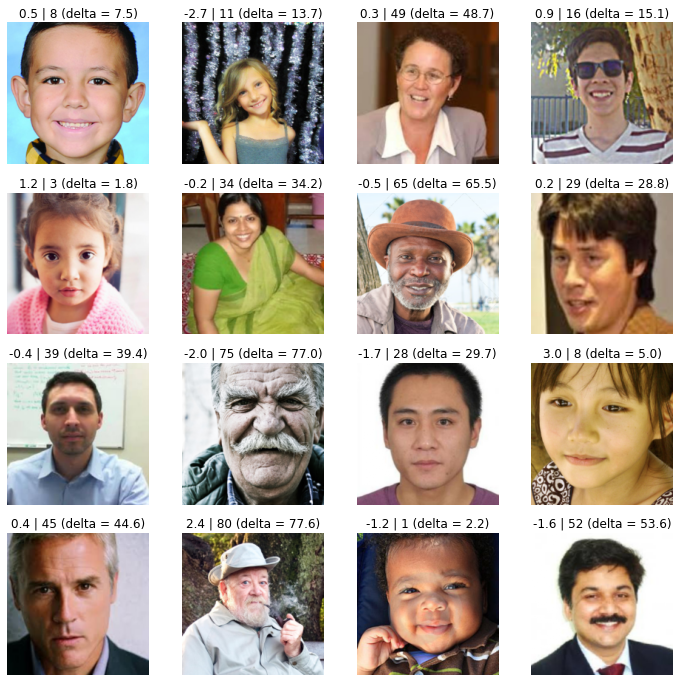

In [14]:
learn.show_results() #como no he entrenado, obvio ahorita es basura, solamente es una prueba

In [15]:
def resnet_split(m):  #esto es porque no se quería que fuerea un sequencial de sequencials
    return fv.L(m[:6], m[6:-8],m[-8:]).map(fv.params) #así fue como parte fastai las redes

In [16]:
class Normalizer(nn.Module):
    def __init__(self, mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]): 
        super().__init__()
        self.mean = torch.tensor(mean)[None,:,None,None]
        self.std = torch.tensor(std)[None,:,None,None]
        
    def forward(self,x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x-m)/s

In [17]:
#No quiere la ReLU, quiere Leaky ReLU

In [18]:
def create_learner(**kwargs):
    layers = [Normalizer()] #1: normalizo
    layers += list(fv.resnet18(pretrained=True).children())[:-2] #1 solamente tomé las capas de resnet18 con .children: es un generador que pasa por todas las capas
    #las últimas dos no las tomamos 
    head = fv.create_head(1024,1,ps=0.4) #1: te da el primer pedacito
    head[5] = nn.LeakyReLU()
    layers += list(head)
    model = nn.Sequential(*layers) #1
    learn = fv.Learner(data,model,opt_func=fv.ranger,splitter=resnet_split,**kwargs)
    learn.freeze()
    gc.collect()
    return learn


In [23]:
learn = create_learner()

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.25118863582611084)

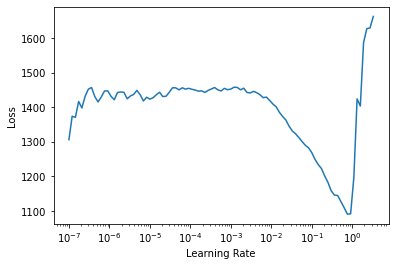

In [24]:
learn.lr_find()

In [25]:
learn.loss_func

FlattenedLoss of MSELoss()

Con regresión hacemos MSE (lo predicho menos lo real y todo al cuadrado). No te asustes con los órdenes de los errores

In [26]:
learn.model

Sequential(
  (0): Normalizer()
  (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (5): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [27]:
learn.fit_one_cycle(6,lr_max=1e-2,div=0.9,pct_start=0.75)

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(6,lr_max=slice(1e-6,1e-3),div=0.9,pct_start=0.75)

### Interpretando el error

Son como años cuadrados, porque estamos usando MLE

In [30]:
91**0.5 #en promedio se está equivocando 9 años y medio

9.539392014169456

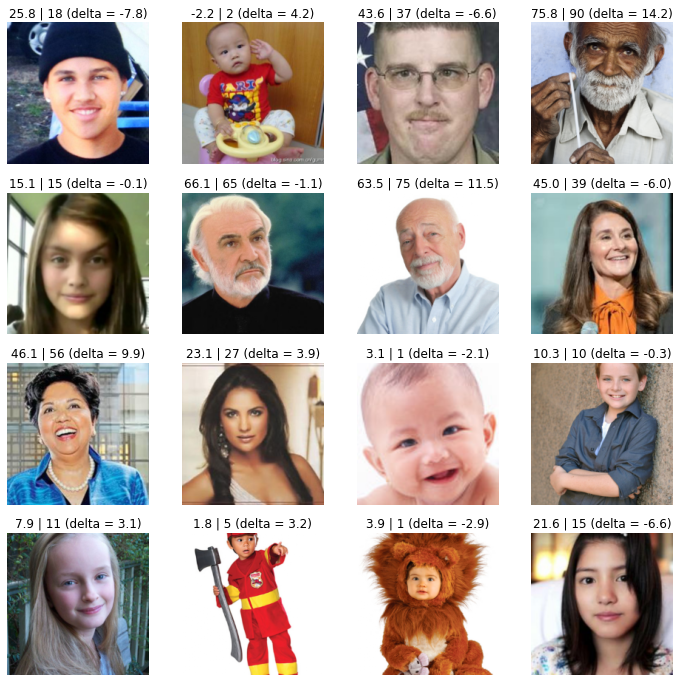

In [32]:
learn.show_results()

Problemas:
1. MSE loss lo tiene todo en cuadrado. A MSE le da miedo equivocarse porque se equivoca por mucho. Todo lo jala hacie el centro: los 30's (donde están todos los datos, de hecho). Es raro que la red neuronal diga números muy extremos si la entrenas con MSE.

2. ¡Da cosas negativas! 

3. No está tan fácil de interpretar el loss.

Con todo esto, no va a ser súper perfecto (porque ni uno como huumano lo hace increíble), solamente de manera razonable. 


## L1 loss:


In [33]:
learn = create_learner(loss_func=F.l1_loss)

In [35]:
learn.fit_one_cycle(2)

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/torch_core.py:317: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  with torch._C.DisableTorchFunction(): ret = _convert(func(*args, **(kwargs or {})), self.__class__)
/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/torch_core.py:317: UserWarning: Using a target size (torch.Size([84])) that is different to the input size (torch.Size([84, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  with torch._C.DisableTorchFunction(): ret = _convert(func(*args, **(kwargs or {})), self.__class__)


Ahora escupe la red dice que escuche 128x1 y nuestro coso real es de 128 solamente. Este error,en la versión 1, no te avisaba, pero ya hace las cosas.

El broadcasting está molestando. 

In [36]:
x,y = data.one_batch()

In [38]:
y.shape

torch.Size([128])

In [40]:
learn.model(x).shape

torch.Size([128, 1])

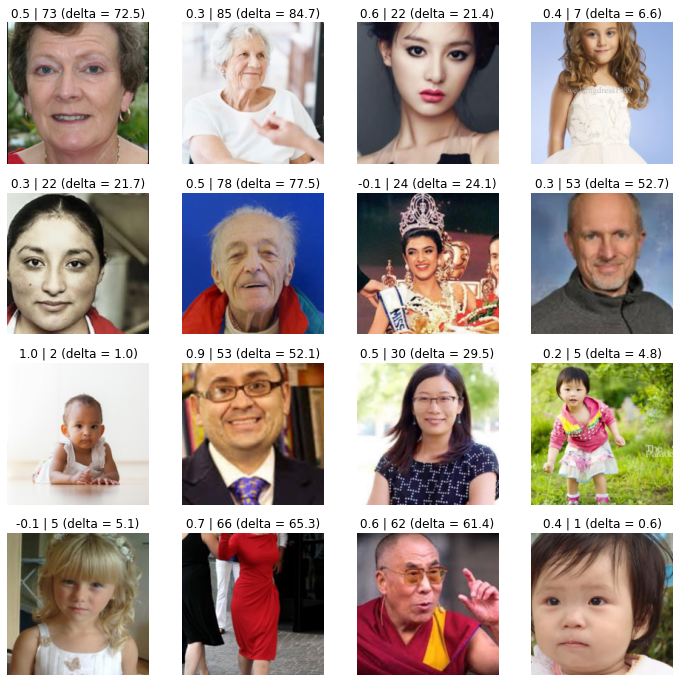

In [41]:
learn.show_results() #son básicamente tonterías

## ¿Cómo lo resolvemos?
1. Crear nuestra propia función de error.

In [42]:
def l1_flat(yp,y):
    yp=yp.view(-1) #le quitamos ese 1 básicamente (no uses squeeze)
    return F.l1_loss(yp,y)

In [48]:
def mse_flat(yp,y):
    yp=yp.view(-1)
    return F.mse_loss(yp,y)
from math import sqrt
def sqrt_mse_flat(yp,y):
    yp=yp.view(-1)
    return torch.sqrt(F.mse_loss(yp,y))

In [49]:
learn = create_learner(loss_func=l1_flat,metrics=[mse_flat,sqrt_mse_flat])

In [50]:
learn.fit_one_cycle(10,lr_max=1e-2,div=0.9,pct_start=0.75)

In [53]:
learn.unfreeze()

In [55]:
learn.fit_one_cycle(4,lr_max=slice(1e-6,1e-3),div=0.9,pct_start=0.75)

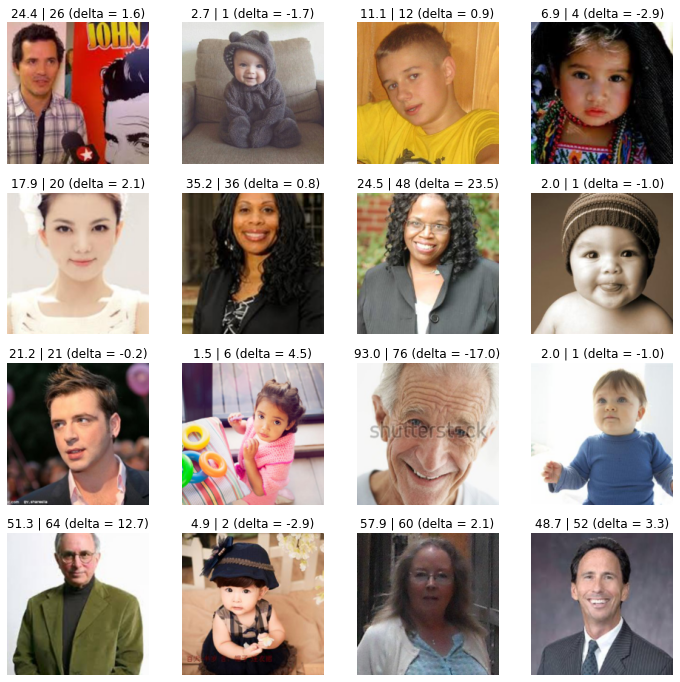

In [56]:
learn.show_results() 

2. Agregar una capa:

In [57]:
class FullFlatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,x):
        return x.reshape(-1)

In [58]:
#learn = create_learner(los_func=F.l1_loss, metrics=F.mse_loss)
#learn.mode = nn.Sequential(learn.model,FullFlatten)

In [59]:
def create_learner(**kwargs):
    layers = [Normalizer()] #1: normalizo
    layers += list(fv.resnet18(pretrained=True).children())[:-2] #1 solamente tomé las capas de resnet18 con .children: es un generador que pasa por todas las capas
    #las últimas dos no las tomamos 
    head = fv.create_head(1024,1,ps=0.4) #1: te da el primer pedacito
    head[5] = nn.LeakyReLU()
    layers += list(head)
    layers += [FullFlatten()] #agregué la capa aquí
    model = nn.Sequential(*layers) #1
    learn = fv.Learner(data,model,opt_func=fv.ranger,splitter=resnet_split,**kwargs)
    learn.freeze()
    gc.collect()
    return learn

In [60]:
learn = create_learner(loss_func=F.l1_loss,metrics=F.mse_loss)

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.12022644281387329)

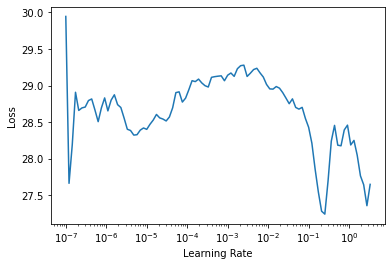

In [61]:
learn.lr_find()

In [62]:
x,y = data.one_batch()

In [63]:
learn.model(x).shape

torch.Size([128])

In [65]:
learn.fit_one_cycle(1,1e-2,div=1)

### Oye, pero siguen saliendo edades negativas

¿Y si lo forzamos a producir números en tre 0 y 116?

In [66]:
import gc
gc.collect()

14371

In [67]:
class AgeLimiter(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return torch.sigmoid(x)*117-0.5 

In [68]:
def l1_plus_mse(yp,y):
    return l1_flat(yp,y) + torch.sqrt(mse_flat(yp,y)) #ese sqrt segundo es para que mse no se lo coma

In [69]:
learn = create_learner(loss_func=l1_plus_mse, metrics=[l1_flat, mse_flat])
learn.model = nn.Sequential(learn.model, AgeLimiter())

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.04786301031708717)

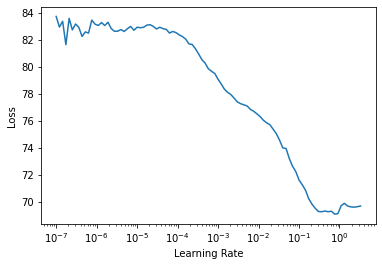

In [70]:
learn.lr_find()

In [71]:
learn.fit_one_cycle(10,2e-2,div=0.9,pct_start=0.75)

In [72]:
learn.unfreeze()

In [73]:
learn.fit_one_cycle(4,lr_max=slice(1e-6,1e-3),div=0.9,pct_start=0.75)

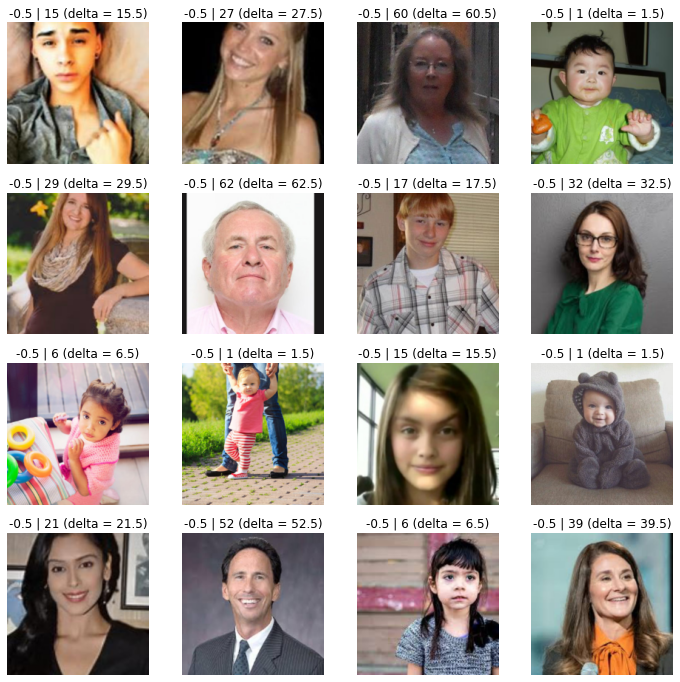

In [74]:
learn.show_results()

## Finalmente

Aunque en este caso L1 funciona bien, la pérdida debe reflejar lo que realmente quieres optimizar. La función que usamos no es muy razonable, la verdad: 5 años de diferencia hacen un abismo en algunas fotos. 

### Si inventamos una función de pérdida mejor:

Buscamos que la diferencia entre valores pequeños sea grande y entre los grandes pequeña. Necesitamos una función cóncava. 

Como el logaritmo.

In [75]:
def age_loss(pred,targ):
    return F.mse_loss(torch.log(pred),torch.log(targ))

In [76]:
def age_loss(pred,targ):
    a = 0.3
    p = (1+pred)**a
    t = (1+targ)**a
    return torch.abs(p-t).mean()

In [77]:
def age_compare(a,b):
    return age_loss(torch.tensor(float(a)), torch.tensor(float(b))).item()

In [79]:
age_compare(2,3), age_compare(15,18), age_compare(90,100)

(0.12532734870910645, 0.12154889106750488, 0.12296032905578613)

In [80]:
learn.loss_func=age_loss

In [82]:
learn.fit_one_cycle(8,lr_max=slice(3e-6,1e-3),div=0.9,pct_start=0.75)

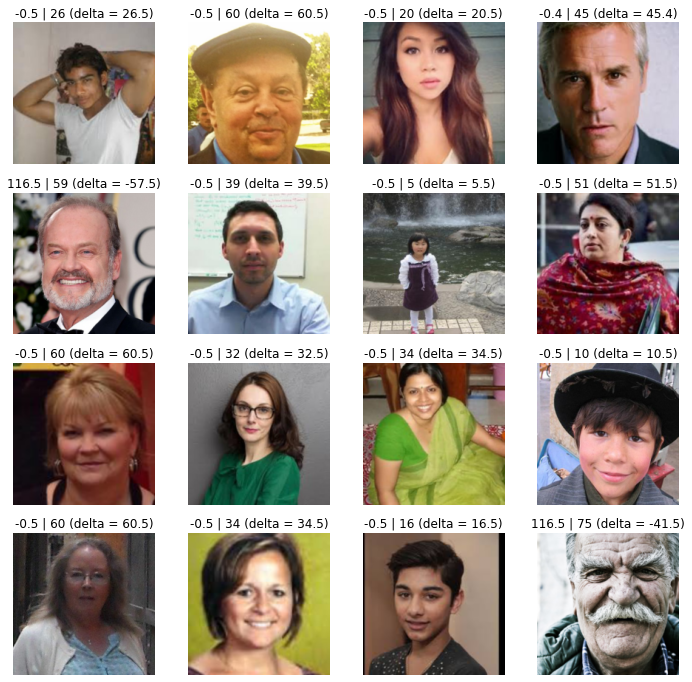

In [83]:
learn.show_results()

In [84]:
learn.save('r18-age')

Path('models/r18-age.pth')